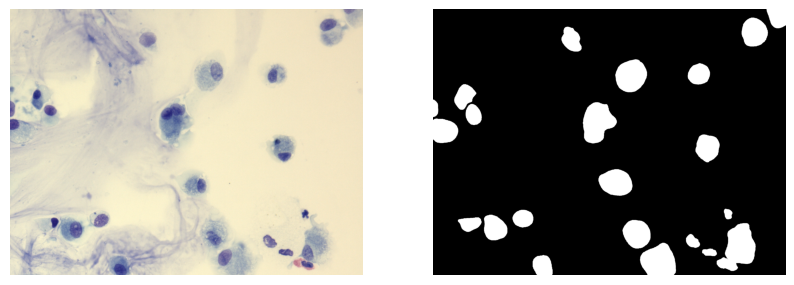

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import io

img_path = Path("images/1.png")
label_path = Path("labels/orig/cytoplasm/1.npy")

img = io.imread(img_path)
ground_truth = np.load(label_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth, cmap="gray")
plt.axis("off")

plt.show()

In [2]:
from rich import print

from optuna import load_study

study = load_study(
    storage="sqlite:///cytoplasm_params.db", study_name="cytoplasm_segmentation"
)

params = study.best_params

print(params)

{
    'sigma': 4.091766703315922,
    'mask_size': 3,
    'iterations': 8,
    'min_size': 155,
    'slope': 8,
    'limit': 1213,
    'samples': 383
}

In [141]:
from optuna.importance import FanovaImportanceEvaluator
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study, evaluator=FanovaImportanceEvaluator())

fig.update_layout(
    template="plotly_white",
    margin=dict(l=0, r=0, t=0, b=0),
    title=None,
    font=dict(size=18),
)

fig.show()

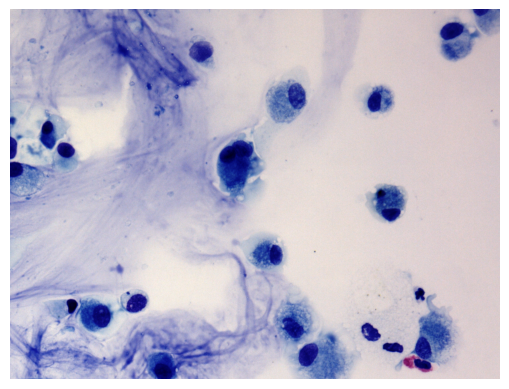

In [ ]:
import colorcorrect.algorithm as cca

img_c_corrected = cca.automatic_color_equalization(
    img,
    slope=params["slope"],
    limit=params["limit"],
    samples=params["samples"],
)

plt.imshow(img_c_corrected)
plt.axis("off")
plt.show()

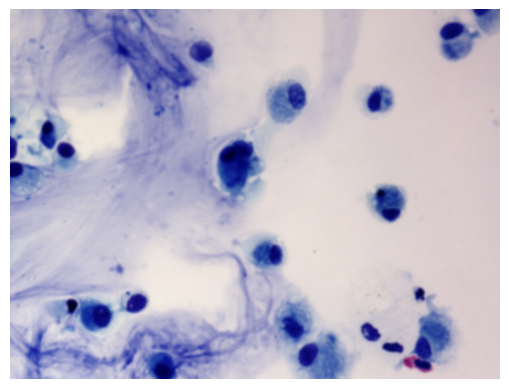

In [144]:
from scipy.ndimage import gaussian_filter

sigma = params.get("sigma")

img_blurred = gaussian_filter(img_c_corrected, sigma=(sigma, sigma, 0))

plt.imshow(img_blurred)
plt.axis("off")
plt.show()

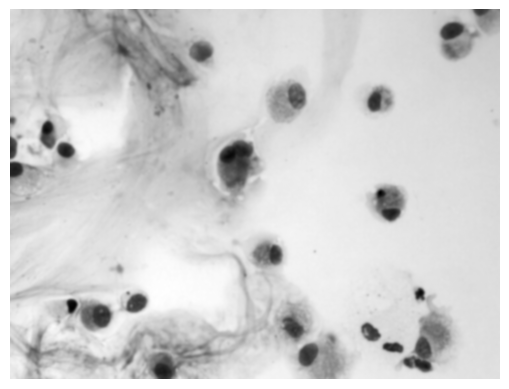

In [145]:
r, g, b = img_blurred[:, :, 0], img_blurred[:, :, 1], img_blurred[:, :, 2]
# r, g, b = RGB_BALANCED[:, :, 0], RGB_BALANCED[:, :, 1], RGB_BALANCED[:, :, 2]


plt.axis("off")
plt.imshow(0.5 * b + 0.5 * g, cmap="gray")
plt.show()

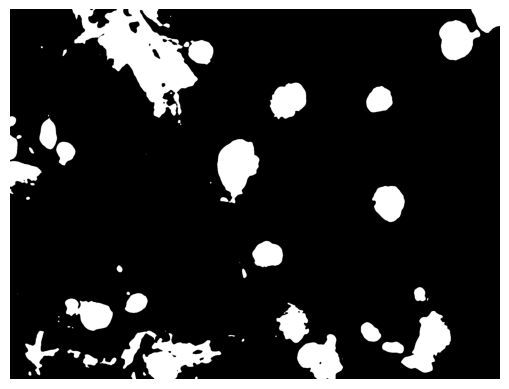

In [146]:
from skimage.filters import threshold_otsu

img_bin = (0.5 * b + 0.5 * g) < threshold_otsu((0.5 * b + 0.5 * g))


plt.axis("off")
plt.imshow(img_bin, cmap="gray")

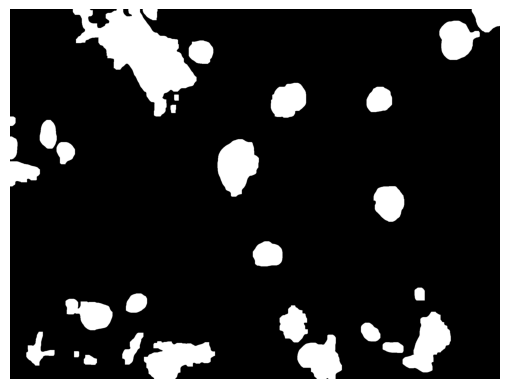

In [147]:
import mahotas as mh


def morph_operations(
    img: np.ndarray, mask_size: int = 3, iterations: int = 5
) -> np.ndarray:
    img_bin = mh.close_holes(img)
    mask = np.ones((mask_size, mask_size))

    for _ in range(iterations):
        img_bin = mh.erode(img_bin, mask)

    for _ in range(iterations):
        img_bin = mh.dilate(img_bin, mask)

    return img_bin


mask_size = params.get("mask_size")
iterations = params.get("iterations")

img_morph = morph_operations(img=img_bin, mask_size=mask_size, iterations=iterations)

plt.axis("off")
plt.imshow(img_morph, cmap="gray")

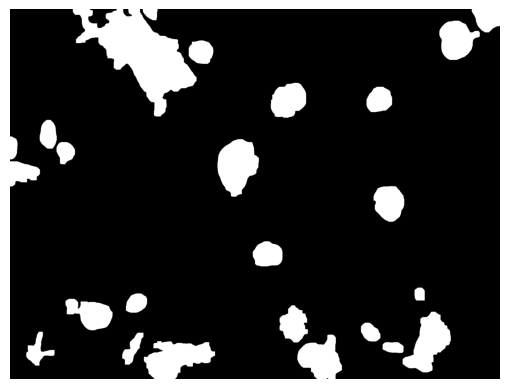

In [148]:
from skimage.morphology import remove_small_objects

min_size = params.get("min_size")
min_size = 2000

cytoplasm = remove_small_objects(img_morph, min_size=min_size)

plt.axis("off")
plt.imshow(cytoplasm, cmap="gray")

In [149]:
from sklearn.metrics import f1_score

f1 = f1_score(ground_truth.flatten(), cytoplasm.flatten())
print("F1 Score:", f1)

F1 Score: 0.667844363963624